# 1. Set Up

In [1]:
!spack find -p tfel

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc
==> 2 installed packages


In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib


In [4]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh
from scipy import optimize
from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting

os.chdir('/mofem_install/jupyter/thomas/mfront_example_test')
    


# 2. Simulation Parameters

In [ ]:
#in MPa
def initialize_parameters():
    params = cm.AttrDict()
    params.global_default_model = cm.PropertyTypeEnum.le
    params.tester = cm.TestAttr(
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=233, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=233, poisson_ratio=0.49, HardeningSlope = 233/100, YieldStress = 6),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=233, poisson_ratio=0.49, phi=np.radians(27), c=5, v=np.radians(27)),
            cm.PropertyTypeEnum.dpNA: cm.DPNAProps(youngs_modulus=233, poisson_ratio=0.3, phi=np.radians(0.05), c=1, v=np.radians(0.05)),
            cm.PropertyTypeEnum.dp_hyperbolic: cm.DruckerPragerHyperbolicProperties(youngs_modulus=233, poisson_ratio=0.49, phi=np.radians(27), c=5, v=np.radians(27), proximity = 0.000000001),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
        
    )
    params.mesh_size = int(10)
 
    # the prescription is always applied to the max_y edge
    # params.prescribed_force = cm.ForceBoundaryCondition(f_x=0,f_y=0,f_z=60)
    params.prescribed_disp = cm.EdgeBoundaryCondition(disp_uz=0.5)
    
    params.time_history = cm.TimeHistory(history = {
        0: 0, 
        0.25: 1, 
        0.5: 0.85, 
        0.75: 0.9, 
        1: 1.0,
        }
    )
    
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 3

    params.final_time = 1 # [s]
    params.time_step = 1 / 200 # [s]
    params.case_name = "test_3D"
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.um_view = f"/mofem_install/jupyter/thomas/um_view"
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.base = "hex"
    return params

In [6]:
params = initialize_parameters()

# 3. Log paths and meta

In [7]:
params = setup.setup(params)

Simulation #165 for the day.


# 4. Generate the mesh

In [8]:
core.generate_mesh(params)

╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.01 seconds, CPU Time: 0.01 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'test_3D_day_89_sim_165_dpNA': 1, 'FIX_X_0': 2, 'FIX_X_1': 3, 'FIX_Y_0': 4, 'FIX_Y_1': 5, 'FIX_Z_0': 6, 'FIX_Z_1': 7, 'test_3D': 8}
Done, taken Wall Time: 0.35 seconds, CPU Time: 0.00 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
{0.0: 0.0, 0.25: 1.0, 0.5: 0.85, 0.75: 0.9, 1.0: 1.0}
[PhysicalGroup(dim=3, tags=[1], name='test_3D', meshnet_id=8, group_type=<PhysicalGroupType.MATERIAL: 1>, preferred_model=<PropertyTypeEnum.dpNA: 'DruckerPragerNonAssociated'>, props={<PropertyTypeEnum.le: 'LinearElasticity'>: ElasticProperties(youngs_modulus=233.0, poisson_ratio=0.499), <PropertyTy

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-14 20:26:32
[0] <inform> UTC time: 2024-11-14 20:26:32
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh test_3D_day_89_sim_165_dpNA nsteps 1
[0] <inform> [MED] Reading mesh test_3D_day_89_sim_165_dpNA nsteps 1
[0] <inform> [MED] Read number of nodes 1000
[0] <inform> [MED] Reading elements 486 of type Quad number of nodes 4
[0] <inform> [MED] Reading elements 729 of type Hex number of nodes 8
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_3D_day_89_sim_165_dpNA
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [read_med] mes

Done, taken Wall Time: 0.34 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 0.38 seconds, CPU Time: 0.00 seconds


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-14 20:26:32
[0] <inform> UTC time: 2024-11-14 20:26:32
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_3D_day_89_sim_165_dpNA
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_X_1                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_Y_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y_1                        
[0] <inform> [MeshsetMng] meshse

{'global_default_model': <PropertyTypeEnum.dpNA: 'DruckerPragerNonAssociated'>,
 'tester': TestAttr(preferred_model=<PropertyTypeEnum.dpNA: 'DruckerPragerNonAssociated'>, props={<PropertyTypeEnum.le: 'LinearElasticity'>: ElasticProperties(youngs_modulus=233.0, poisson_ratio=0.499), <PropertyTypeEnum.vM: 'VMSimo'>: VonMisesProperties(youngs_modulus=233.0, poisson_ratio=0.49, HardeningSlope=2.33, YieldStress=6.0), <PropertyTypeEnum.dp: 'DruckerPragerSimple'>: DruckerPragerProperties(youngs_modulus=233.0, poisson_ratio=0.49, phi=0.47123889803846897, c=5.0, v=0.47123889803846897), <PropertyTypeEnum.dpNA: 'DruckerPragerNonAssociated'>: DPNAProps(youngs_modulus=233.0, poisson_ratio=0.3, phi=0.0008726646259971648, c=1.0, v=0.0008726646259971648), <PropertyTypeEnum.dp_hyperbolic: 'DruckerPragerHyperboloidal'>: DruckerPragerHyperbolicProperties(youngs_modulus=233.0, poisson_ratio=0.49, phi=0.47123889803846897, c=5.0, v=0.47123889803846897, proximity=1e-09), <PropertyTypeEnum.mcc: 'ModCamClay_se

# 5. Running the analysis and export to .vtk file format

In [9]:
core.mofem_compute(params)

╭─────────────╮
│  COMPUTING  │
╰─────────────╯
Command:
['bash', '-c', 'export OMPI_MCA_btl_vader_single_copy_mechanism=none && nice -n 10 mpirun --oversubscribe --allow-run-as-root -np 8 /mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d -file_name /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/test_3D_day_89_sim_165_dpNA_8p.h5m -sdf_file /mofem_install/jupyter/thomas/mfront_example_test/src/sdf.py -order 2 -contact_order 0 -sigma_order 0 -base demkowicz  -ts_dt 0.005 -ts_max_time 1 -mi_lib_path_108 /mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so -mi_block_108 DruckerPragerNonAssociated -mi_param_108_0 0.0008726646259971648 -mi_param_108_1 1.0 -mi_param_108_2 0.0008726646259971648 -mi_param_108_3 233.0 -mi_param_108_4 0.3 -mi_param_108_5 0  -mi_save_volume 1 -mi_save_gauss 0 -time_scalar_file /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_d

In [10]:
core.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯


Conversion to VTK successful.
Moved out_mi_156.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_93.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_155.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_92.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_91.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_154.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_90.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks
Moved out_mi_9.vtk to /mofem_

# 6. Visualize final time step .vtk file

/mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/vtks/out_mi_200.vtk


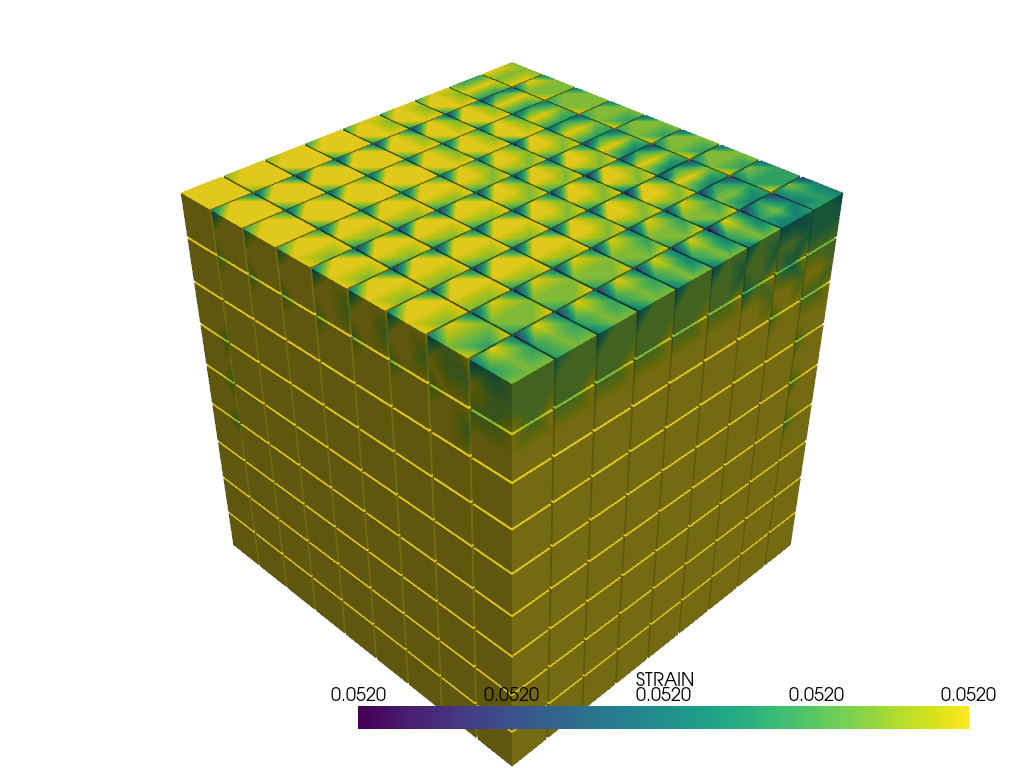

In [11]:
import pyvista as pv
pv.set_plot_theme("document")

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
vtk_files = subprocess.run(f"ls -c1 {params.vtk_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
if vtk_files.returncode == 0:
    files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
    final_file = files[-1]
    print(final_file)
    mesh = pv.read(final_file)
    mesh=mesh.shrink(0.95) 
    warp_factor = 1.0
    # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
    # show_field = "STRESS"
    # show_field = "DISPLACEMENT" # U: displacement
    show_field = "STRAIN" # U: displacement
    
    if mesh.point_data[show_field].shape[1] > 3:
        cmap = "Spectral"
    p = pv.Plotter(notebook=True)
    # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    p.add_mesh(mesh, scalars="STRAIN")
    p.camera_position = 'iso'
    p.show(jupyter_backend='ipygany')
    p.screenshot(f"{params.graph_dir}/final_strain.png")
    p.clear()
    p.add_mesh(mesh, scalars="STRESS")
    p.camera_position = 'iso'
    p.screenshot(f"{params.graph_dir}/final_stress.png")
    p.clear()
    p.add_mesh(mesh, scalars="DISPLACEMENT")
    p.camera_position = 'iso'
    p.screenshot(f"{params.graph_dir}/final_displacement.png")
    p.clear()

# 7. Extract data from .vtk files 
Tools:
pvpython

In [12]:
paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"

original_pythonpath = os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] = ""
# Properly format the command in Python
# Construct the command as a list of strings

@ut.track_time("PULLING A SELECTED POINT OVER TIME WITH pvpython")
def to_csv():
    command = [
        paraview_path,
        "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/point_to_time_csv.py",
        params.vtk_dir,
        params.point_to_time_filepath,
        str(int(params.mesh_size/2)),
        str(int(params.mesh_size/2)),
        str(int(params.mesh_size/2)),
    ]
    # Run the command using subprocess
    try:
        process = subprocess.run(command, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
    # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath
        
to_csv()
df = pd.read_csv(params.point_to_time_filepath)
strain_magnitude = np.array(df['avg(STRAIN (Magnitude))'])
color_max = strain_magnitude.max()
color_min = strain_magnitude.min()

@ut.track_time("ANIMATING OVER TIME WITH pvpython")
def animate():
    command = [
        paraview_path,
        "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/test_3D_animate.py",
        params.vtk_dir,
        params.strain_animation_filepath_png,
        str(color_min),
        str(color_max),
    ]
    # Run the command using subprocess
    try:
        process = subprocess.run(command, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
    # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath

#Stitch together animations
@ut.track_time("STITCHING .pngs TOGETHER with ffmpeg")
def create_mp4_from_png_sequence(animation_filepath_png_ffmpeg_regex, animation_filepath_mp4, framerate=40):
    # Build the ffmpeg command
    ffmpeg_command = [
        '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg',
        '-framerate', str(framerate),  # Set input framerate
        '-y',
        '-i', animation_filepath_png_ffmpeg_regex,  # Input image sequence (with regex pattern)
        '-c:v', 'libx264',  # Set video codec to libx264
        '-pix_fmt', 'yuv420p',  # Set pixel format for compatibility
        '-loglevel', 'warning',
        animation_filepath_mp4  # Output .mp4 file
    ]

    # Run the ffmpeg command as a subprocess
    try:
        subprocess.run(ffmpeg_command, check=True, capture_output=True)
        print(f"MP4 video created successfully: {animation_filepath_mp4}")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred during ffmpeg execution: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
animate()
create_mp4_from_png_sequence(params.strain_animation_filepath_png_ffmpeg_regex, params.strain_animation_filepath_mp4, framerate=40)


╭────────────────────────────────────────────────────╮
│  PULLING A SELECTED POINT OVER TIME WITH pvpython  │
╰────────────────────────────────────────────────────╯
Done, taken Wall Time: 15.22 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  ANIMATING OVER TIME WITH pvpython  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 80.59 seconds, CPU Time: 0.00 seconds
╭────────────────────────────────────────╮
│  STITCHING .pngs TOGETHER with ffmpeg  │
╰────────────────────────────────────────╯
MP4 video created successfully: /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/test_3D_day_89_sim_165_dpNA.mp4
Done, taken Wall Time: 0.68 seconds, CPU Time: 0.00 seconds


exx: 0.01
eyy: 0.01
ezz: -0.05
sig1: -5.1658
sig2: -5.1658
sig3: -7.1765
p: -5.836033333333333
J2: 1.347638163333333
J: 1.1608781862595803
sig_eq: 2.0107


'/mofem_install/jupyter/thomas/mfront_example_test/simulations/test_3D_day_89_sim_165_20241114_202631_dpNA/graphs/304_ev_ed.png'

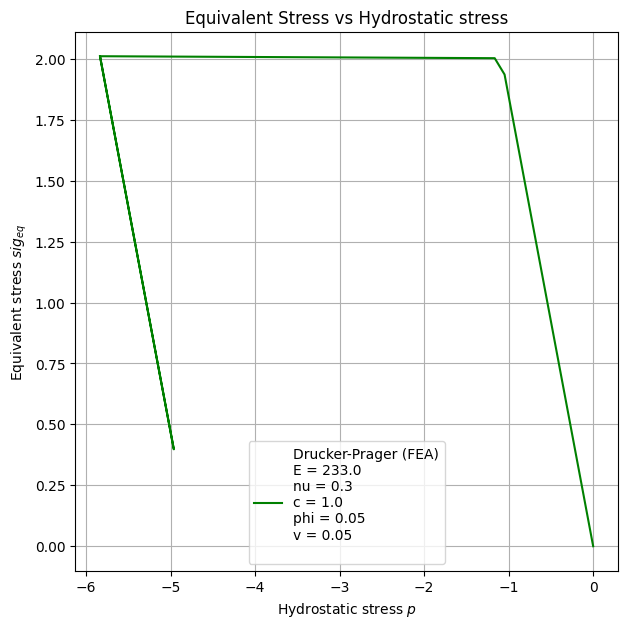

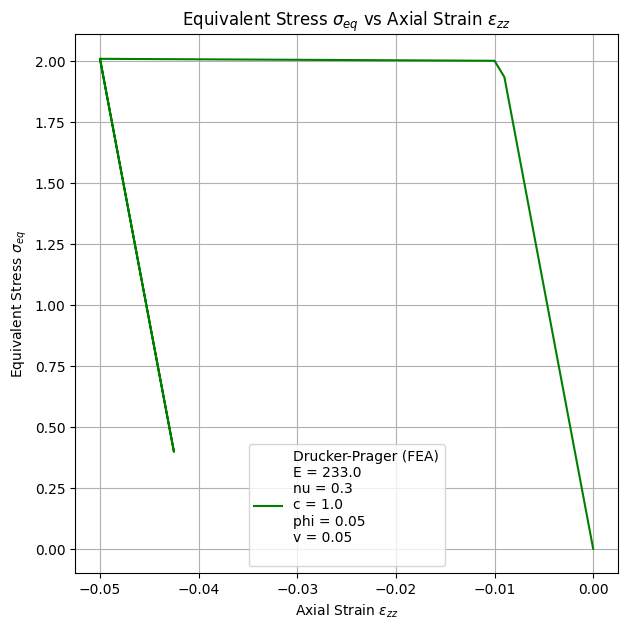

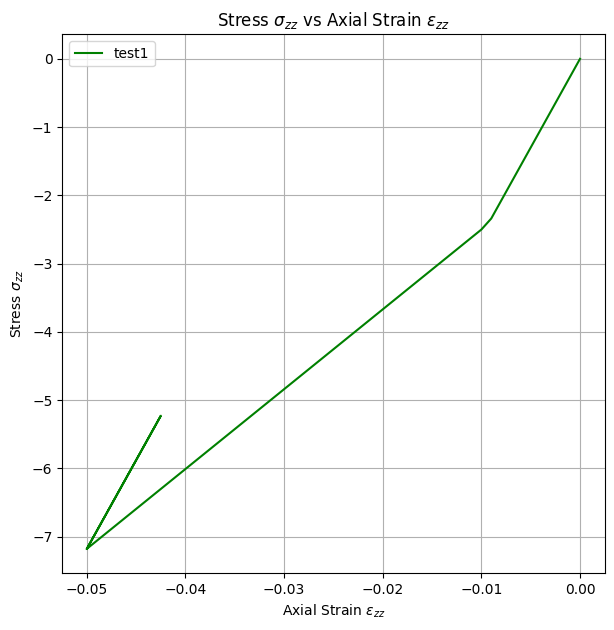

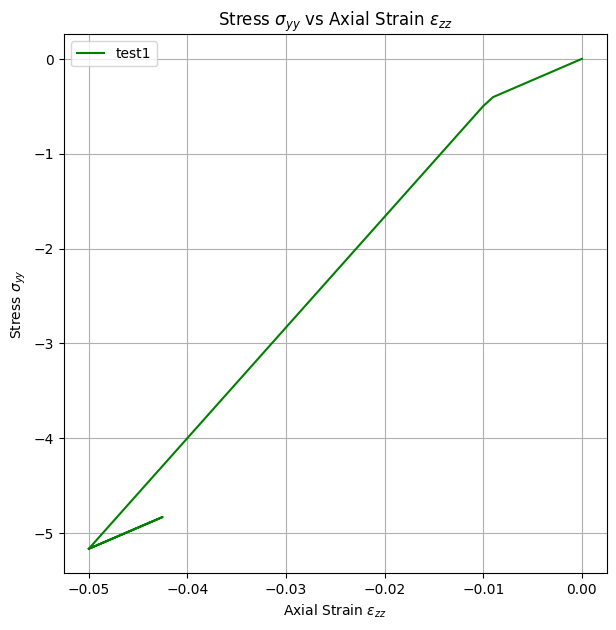

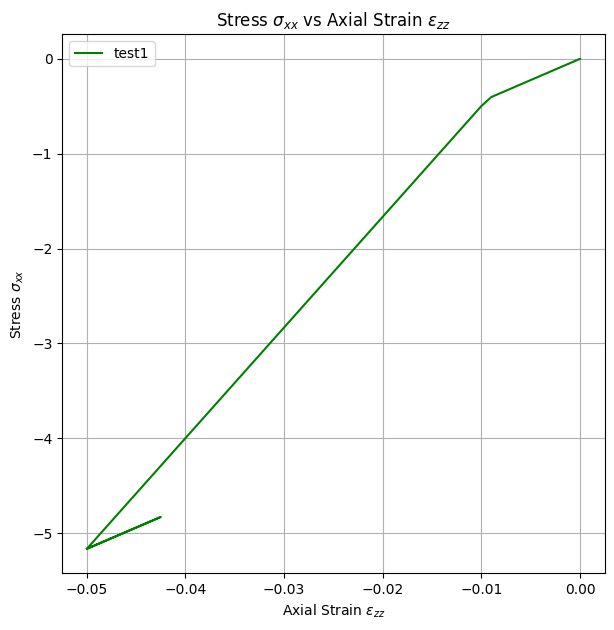

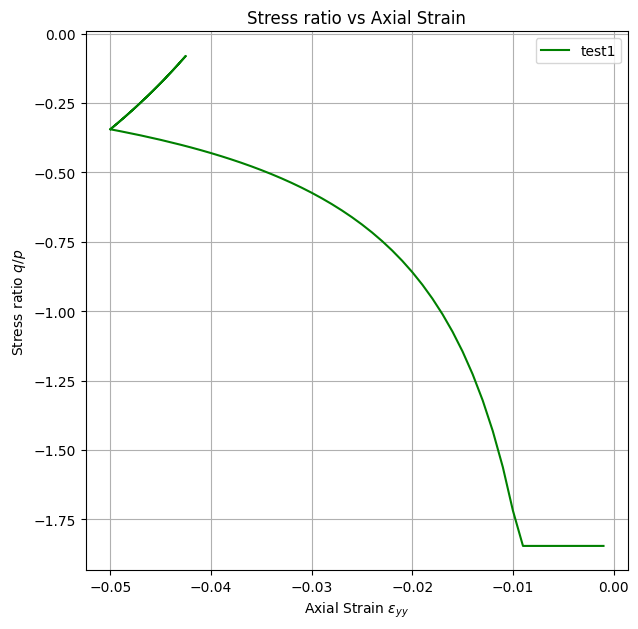

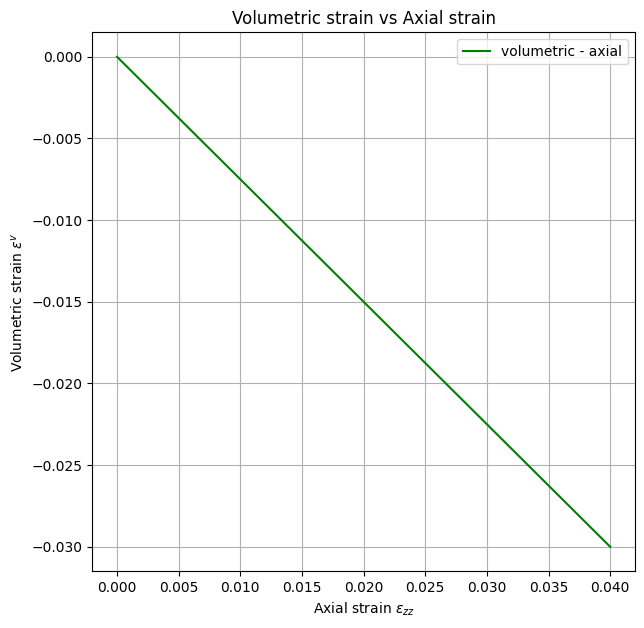

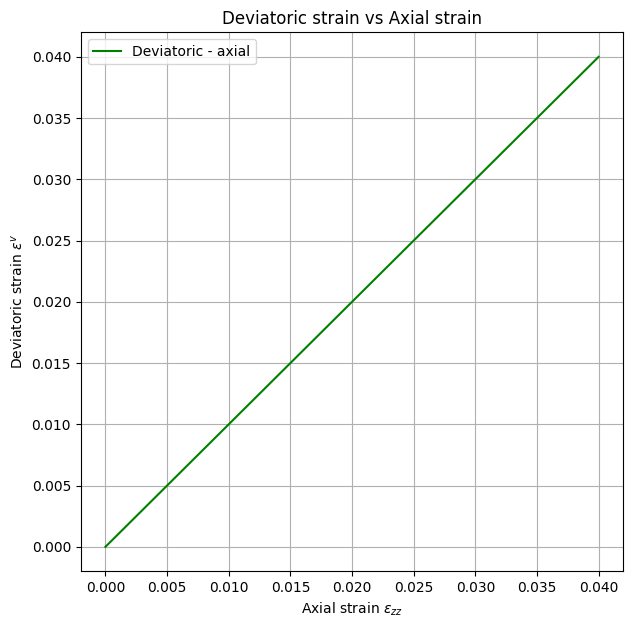

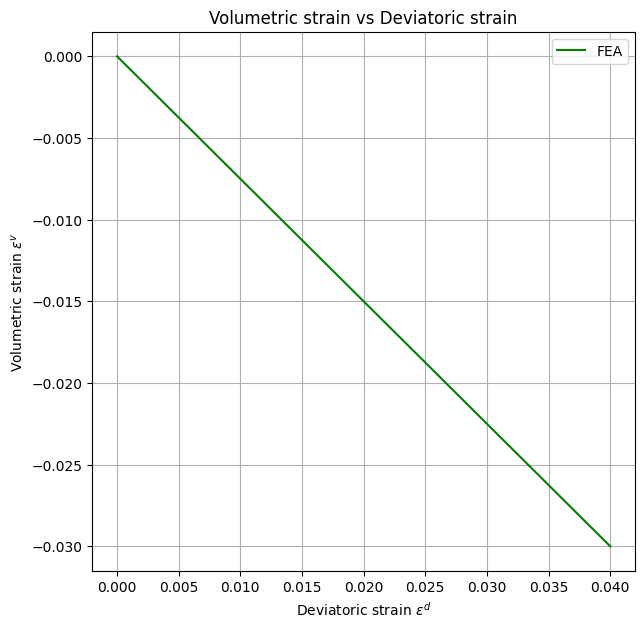

In [13]:
import sys

import matplotlib
import numpy as np
sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import plotting
import calculations as calc


matplotlib.rc('figure', figsize=(7, 7))
import pandas as pd
df = pd.read_csv(params.point_to_time_filepath)
sig_xx = np.array(df['avg(STRESS (0))'])
sig_xy = np.array(df['avg(STRESS (1))'])
sig_xz = np.array(df['avg(STRESS (2))'])
sig_yy = np.array(df['avg(STRESS (4))'])
sig_yz = np.array(df['avg(STRESS (5))'])
sig_zz = np.array(df['avg(STRESS (8))'])

e_xx = np.array(df['avg(STRAIN (0))'])
e_xy = np.array(df['avg(STRAIN (1))'])
e_xz = np.array(df['avg(STRAIN (2))'])
e_yy = np.array(df['avg(STRAIN (4))'])
e_yz = np.array(df['avg(STRAIN (5))'])
e_zz = np.array(df['avg(STRAIN (8))'])

sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
p = calc.calculate_p(sig_1, sig_2, sig_3)
J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
J  = np.sqrt(J_2)
tau_oct = np.sqrt(2 * J_2)
sig_eq = np.sqrt(3 * J_2)
e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)

def plot_x_ys(x_array: list, y_arrays, labels: list, cutoffs=None, x_label="", y_label="", title="", save_as: str = None):
    data = []
    for i in range(len(y_arrays)):
        data.append((x_array, y_arrays[i], labels[i], 'g', None))
    return plotting.create_plot(data, x_label, y_label, title, save_as)
print(f"exx: {e_xx[-1]}")
print(f"eyy: {e_yy[-1]}")
print(f"ezz: {e_zz[-1]}")
print(f"sig1: {sig_1[-1]}")
print(f"sig2: {sig_2[-1]}")
print(f"sig3: {sig_3[-1]}")
print(f"p: {p[-1]}")
print(f"J2: {J_2[-1]}")
print(f"J: {J[-1]}")
print(f"sig_eq: {sig_eq[-1]}")
label = f"""Drucker-Prager (FEA)
E = {params.tester.props[params.global_default_model].youngs_modulus}
nu = {params.tester.props[params.global_default_model].poisson_ratio}
c = {params.tester.props[params.global_default_model].c}
phi = {np.degrees(params.tester.props[params.global_default_model].phi)}
v = {np.degrees(params.tester.props[params.global_default_model].v)}
"""
plot_x_ys(p, [sig_eq], labels=[label], x_label='Hydrostatic stress $p$', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs Hydrostatic stress', save_as = f"{params.graph_dir}/111_sigeq_p.png")

plot_x_ys(e_zz, [sig_eq], labels=[label], x_label='Axial Strain $\epsilon_{zz}$', y_label='Equivalent Stress $\sigma_{eq}$', title='Equivalent Stress $\sigma_{eq}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{params.graph_dir}/201_sigeq_eyy.png")
plot_x_ys(e_zz, [sig_zz], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{zz}$', title='Stress $\sigma_{zz}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{params.graph_dir}/201_sigeq_ezz.png")
plot_x_ys(e_zz, [sig_yy], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{yy}$', title='Stress $\sigma_{yy}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{params.graph_dir}/201_sigeq_eyy.png")
plot_x_ys(e_zz, [sig_xx], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{params.graph_dir}/201_sigeq_exx.png")

plot_x_ys(e_zz[1:], [sig_eq[1:]/p[1:]], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{params.graph_dir}/211_sigeq_div_p_eyy.png")

plot_x_ys(e_d, [e_v], labels=["volumetric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Axial strain', save_as = f"{params.graph_dir}/302_ev_ed.png")
plot_x_ys(e_d, [e_d], labels=["Deviatoric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Deviatoric strain $\epsilon^v$', title='Deviatoric strain vs Axial strain', save_as = f"{params.graph_dir}/303_ev_ed.png")
plot_x_ys(e_d, [e_v], labels=["FEA"], x_label='Deviatoric strain $\epsilon^d$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Deviatoric strain', save_as = f"{params.graph_dir}/304_ev_ed.png")
